<br />
<p align="center">
  <h1 align="center">TEL531</h1>
  <h1 align="center">Statistical Pattern Analysis & Classification</h1>
  <h2 align="center">Principal Component Analysis</h2>
  <h3 align="center">Selahaddin Honi</h3>
  </p>
</p>

### Training Data
In this study, we have 10 face samples of different identities from **Yale Face Database B**. These image samples are stored in gray-scale pixel intensities with $(192,168)$ dimensions. Below routine reads and flattens them to construct a training set **X** with a shape of $(10,32256)$. Original faces are displayed in **copper color-map**.

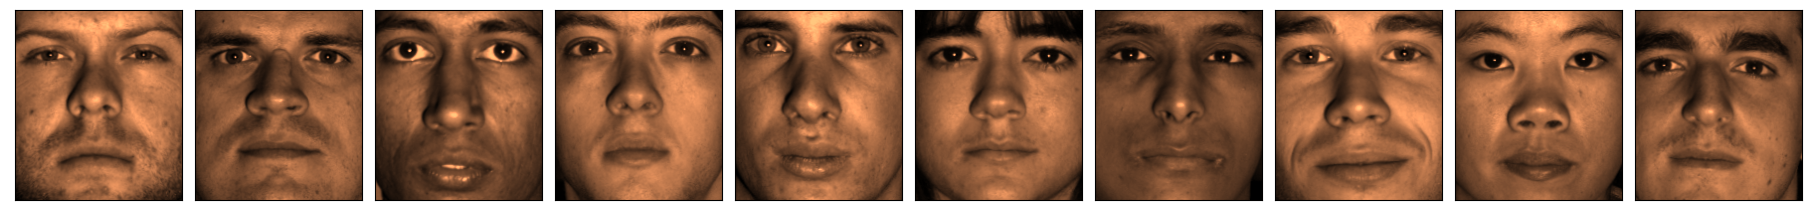

In [2]:
img_vector_list = []
path_main = "./face_Yale/"
img_path_list = [os.path.join(path_main,path_img) for path_img in os.listdir(path_main)]
for img_path in img_path_list:
    img = mpimg.imread(img_path) 
    imshape = img.shape # (192,168)
    img_vector = img.flatten() # (32256,)
    img_vector_list.append(img_vector)
X = np.array(img_vector_list) # (10,32256)
plot_faces(X,imshape=imshape,cmap=cmap)

### PCA & Eigenfaces 
PCA implementation of Sklearn library have three basic parameters: **n_components**, **whiten** and **svd_solver**. <br>

If **n_components** is in $[0,1]$ interval; then, algorithm returns you the components which explains the dataset variance by that specified value. If it is not specified ($None$), we can reach all components to make further analysis. However, it is good to know that evaluated maximum number of components are limited to the smallest size of the data: 
$$n\_components = min(n\_samples,n\_features) = 10 $$

**n_whiten** is such a normalization that principal components are multiplied by the square root of $n\_samples$ and divided by singular values. This process makes uncorrelated outputs to have unit variances. Since, whitening changes (eliminates some information) the training data, keep it $False$ for our toy example. (False by default)

**svd_solver** determines how the eigen-vectors are calculated. In our case, we have large feature set ($n\_features = 32256$) and this makes the calculation of eigen-value and eigen-vectors not efficient. Choosing $svd\_solver = auto$ will result in use of Randomized Singular Value Decomposition method (Halko et al) to solve this problem. It is an intelligent way to aproximate the first principal components quickly. 


 

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None,whiten=False,svd_solver='auto').fit(X)
eigenfaces = pca.components_
coeffs = pca.transform(X)

Evaluated PCA components are stored in **eigenfaces** variable. **coeffs** is the weights for each eigenface to transform the original face to projection space. 
$$coeffs = X \cdot eigenfaces^T $$
Here are the first 10 eigenfaces of the training set, respectively:


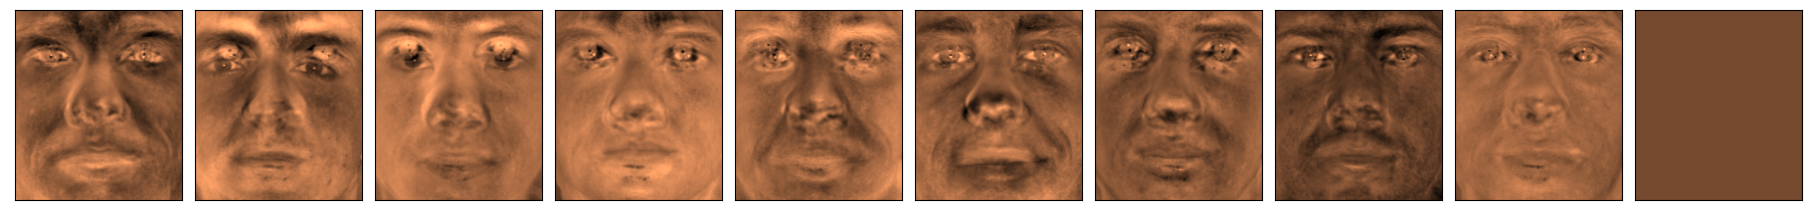

In [4]:
plot_faces(pca.components_,imshape=imshape,cmap=cmap)

Because $9$ eigenfaces can cover all the training samples $10^{th}$ eigen face seems like it does not exist. 

### How to choose $k$ eigenfaces?
Explained variance is a measurement of importance for each component to represent the data. One component's explained variance is approximately equal to the ratio of corresponding eigen-value to the sum of all eigen-values. Therefore, we can arrive an expression of cumulative sum by combining $k$ components:
$$ Explained \, Var(k) = \frac{\sum_i^k \lambda_i}{ \sum_{i}^N \lambda_i } $$
where N is the total number of components and $k\leq N$.

In the below figure, horizontal axis is the number of principal components (eigenfaces) and vertical axis is the explained variance approximation. Inspecting the cumulative explained variance (orange plot) can lead us to choose $k=5$ for $80$% explained variance desire.

Again, $10^{th}$ eigenface has no impact to the data representation and the cumulative explained variance succeed to reach the top $1.0$ with $9$ eigenfaces.

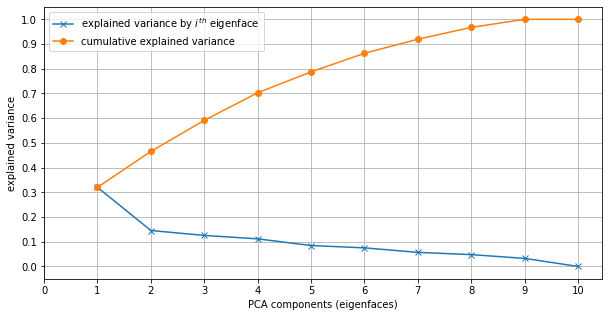

In [5]:
fig = plt.figure(figsize=(10,5))
plt.plot(np.arange(1,11,1),pca.explained_variance_ratio_,marker='x',\
    label='explained variance by $i^{th}$ eigenface')
plt.plot(np.arange(1,11,1),np.cumsum(pca.explained_variance_ratio_),marker='o',\
    label='cumulative explained variance')
plt.xticks(np.arange(0,11,1)); plt.yticks(np.arange(0,1.1,0.1))
plt.xlabel('PCA components (eigenfaces)'); plt.ylabel('explained variance')
plt.grid(); plt.legend(); plt.show()

### Projection and Error
Eigenfaces and their identity-based coefficients are evaluated, already. Projection is simply adding the weighted summation of these eigenfaces and coefficients to the mean face of the training samples. This progress is visualized based on an illustration made by [Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/06.00-figure-code.html#Digits-Pixel-Components). My implementation is available at the bottom of this report.

The original face is located in the most left of the below figure. The eigenfaces are followed the mean face in the first row of the 2D face array. Between the first and second row of the 2D face array, coefficients correspond to related eigenfaces are placed. In the second row, there are projections with $i=\{1,...,k\}$ eigenfaces, where $i$ increased by column and $k$ is the specified eigenface number in the last section. The values under these projections are their L2 norms to the original face. $k^{th}$ column projection starting after the mean face is the final projection and also displayed in the most right of the figure.

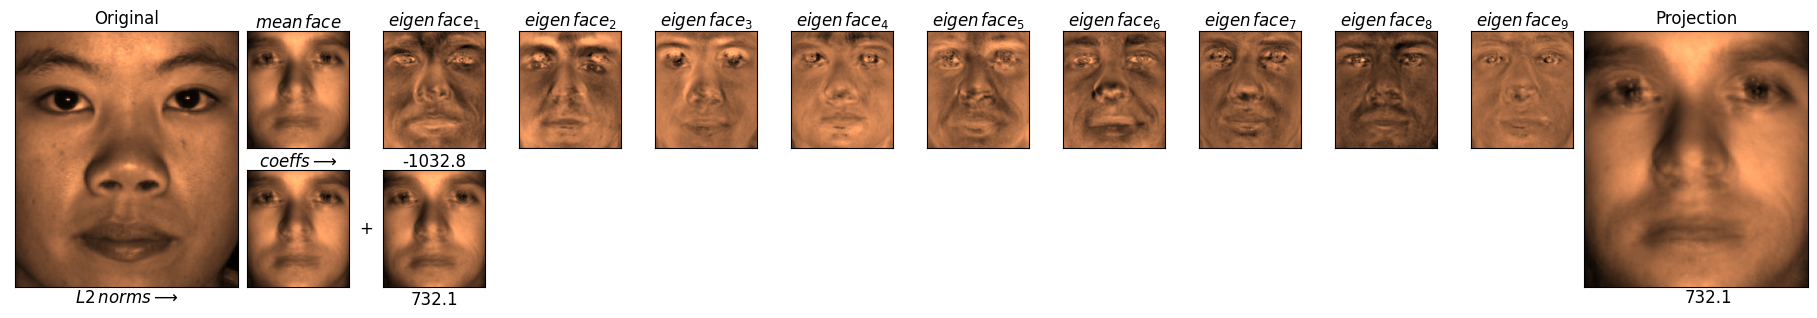

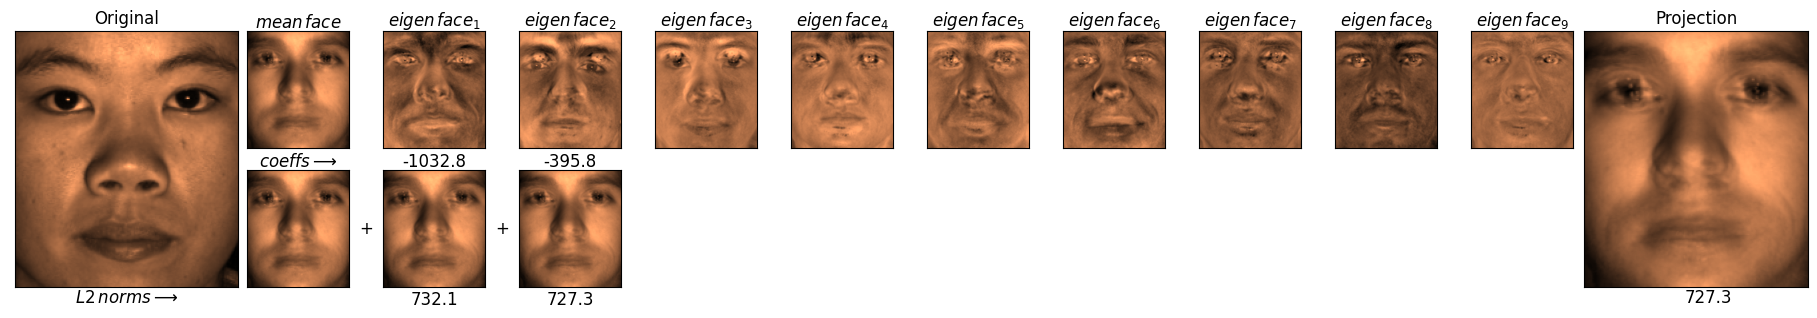

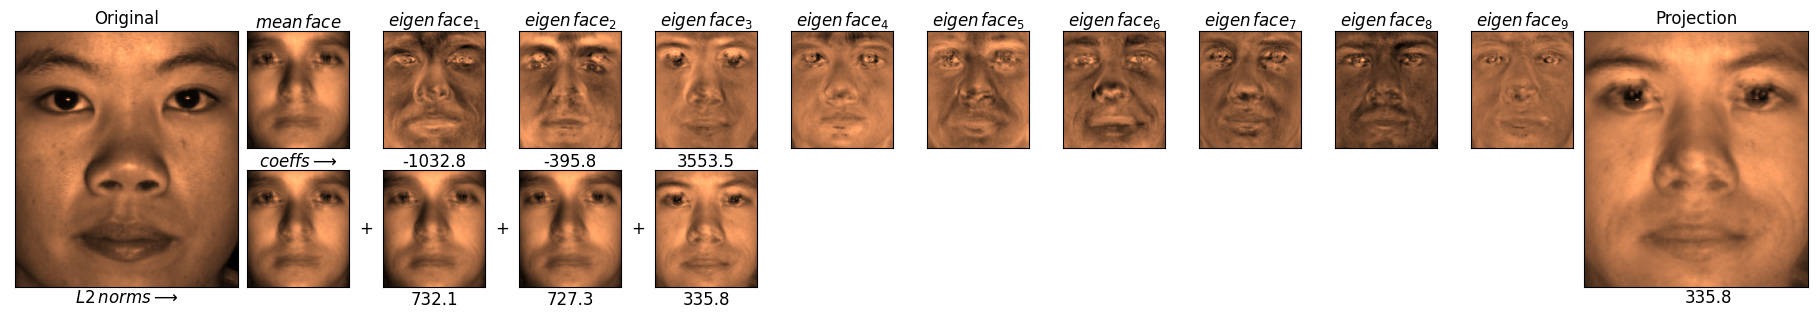

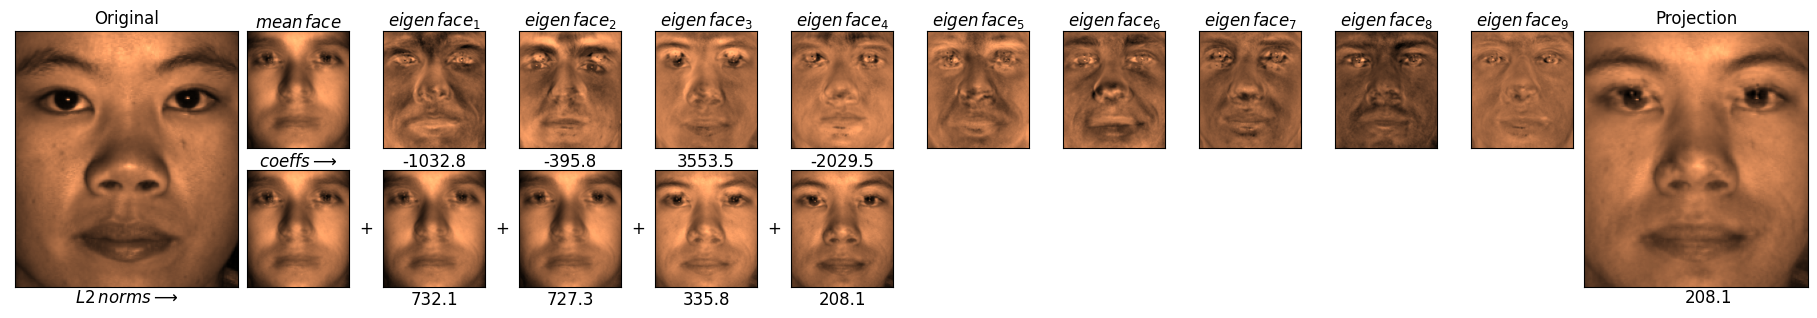

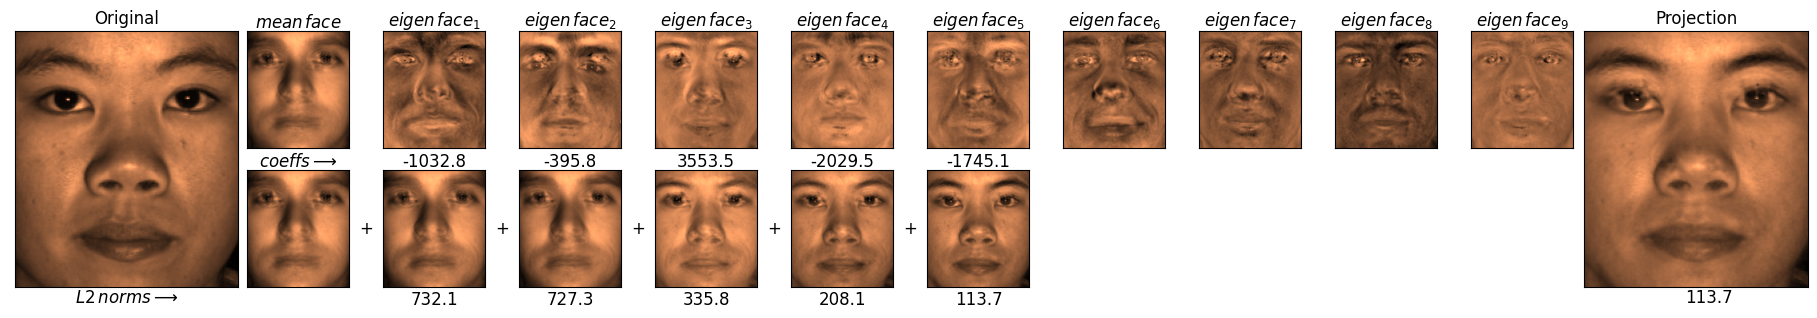

In [6]:
k = 5
for i in range(1,k+1):
    plot_pca_projection(
        im_face=X[8],
        mean_face=np.mean(X,axis=0),
        eigenfaces=eigenfaces,
        coeffs=coeffs[8],
        n_components=9,
        k_components=i,
        imshape=imshape,
        cmap=cmap
        )

### Utilizing PCA for Storage Purpose
Let's make an approximate analysis on a question of how much memory space we are required to store the **10** faces.
Say, **S** is the memory allocation for one face of the dataset **X**. Thus, in total **10S** space is required without PCA.
In this application, we have found that $k=5$ eigenfaces performed acceptable results to represent the **X**. Therefore, we might store **5** eigenfaces, **1** mean face and relatively small coefficients matrix to reconstruct the **X**. If memory need for coefficients is denoted as **eps** total memory need can be evaluated to **6S+eps**.

Finally, we infer from the assumptions above that PCA has provided **almost 40%** gain in terms of memory space.

### Projections for Each Identity

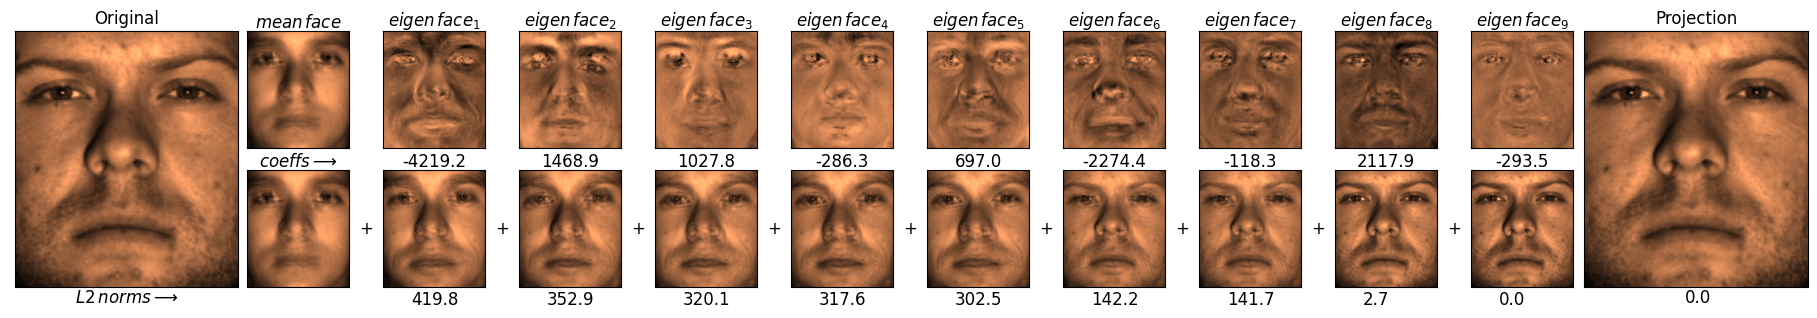

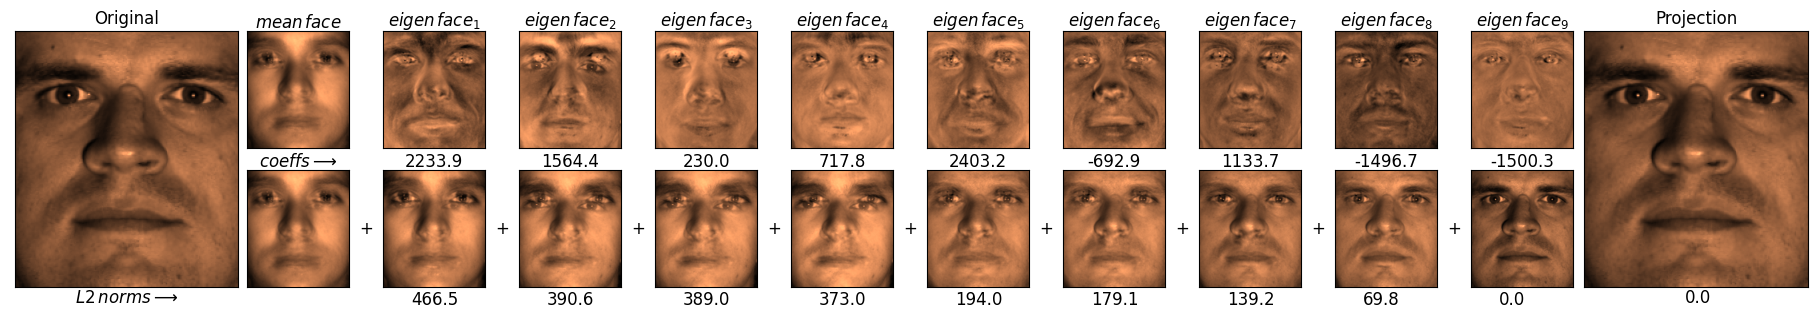

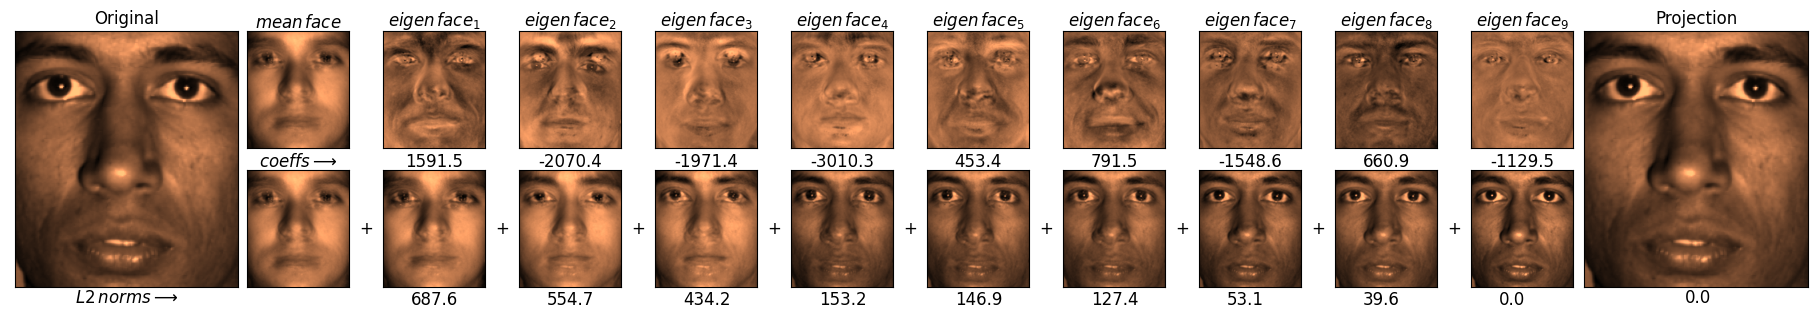

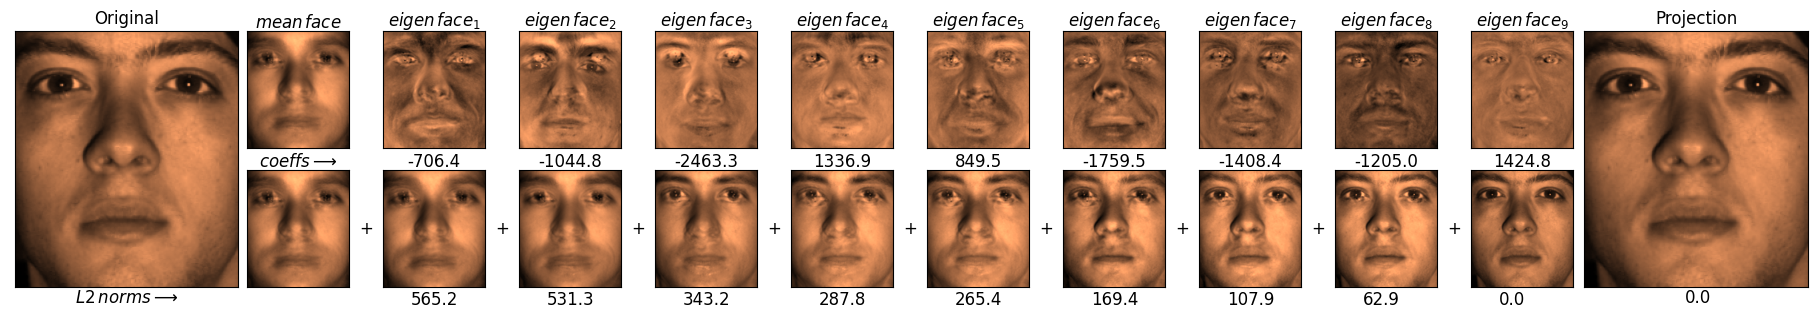

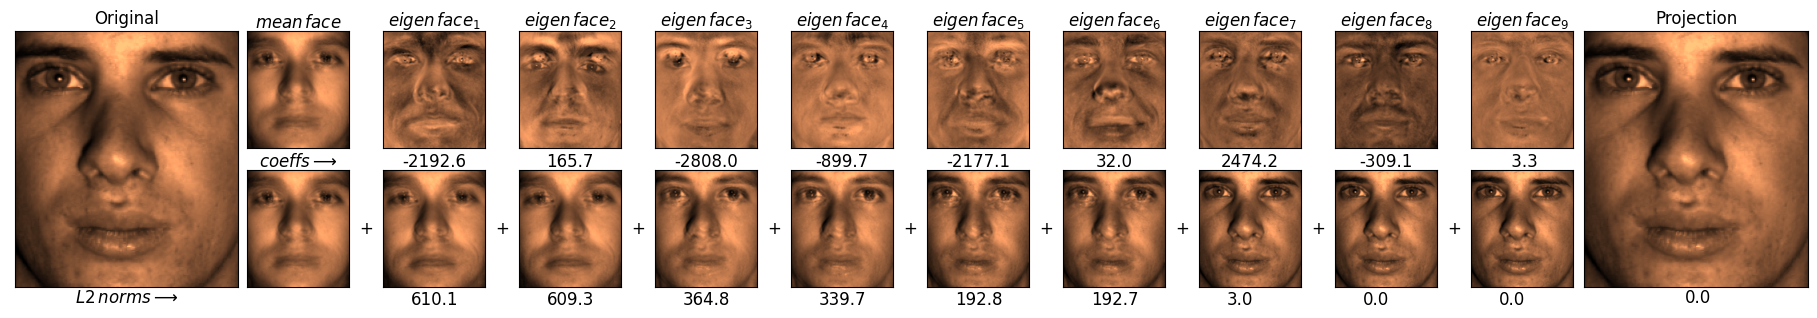

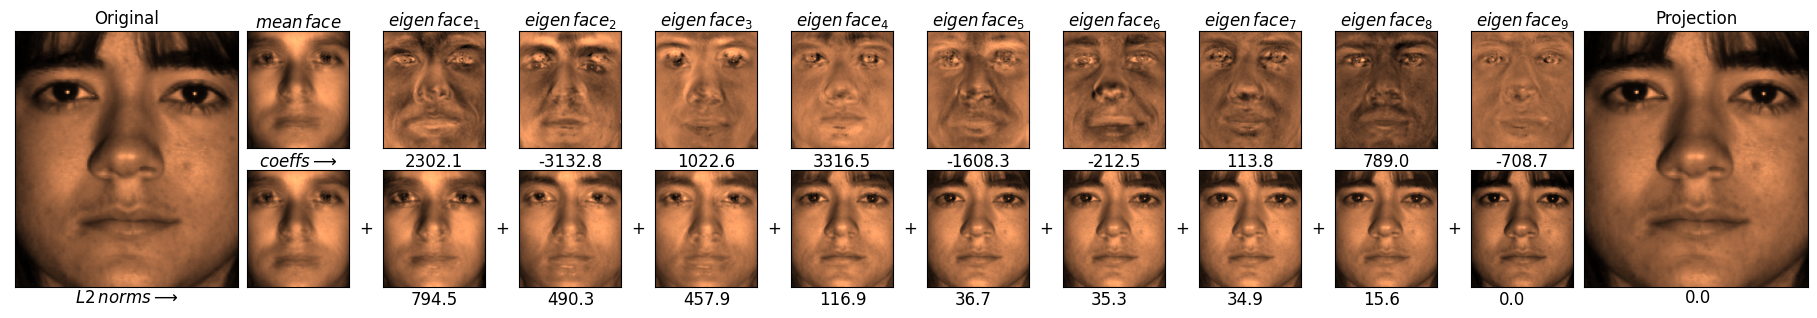

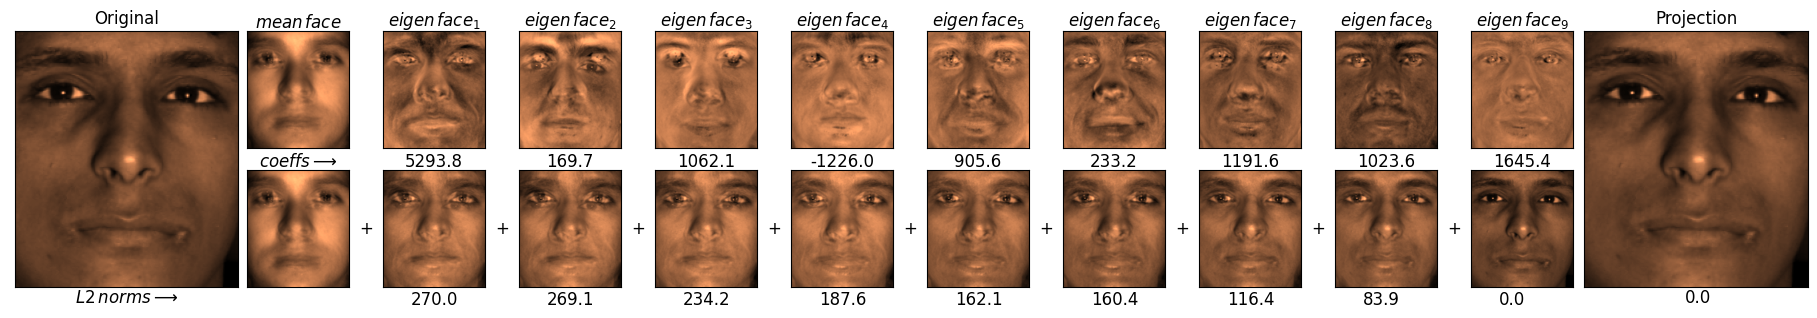

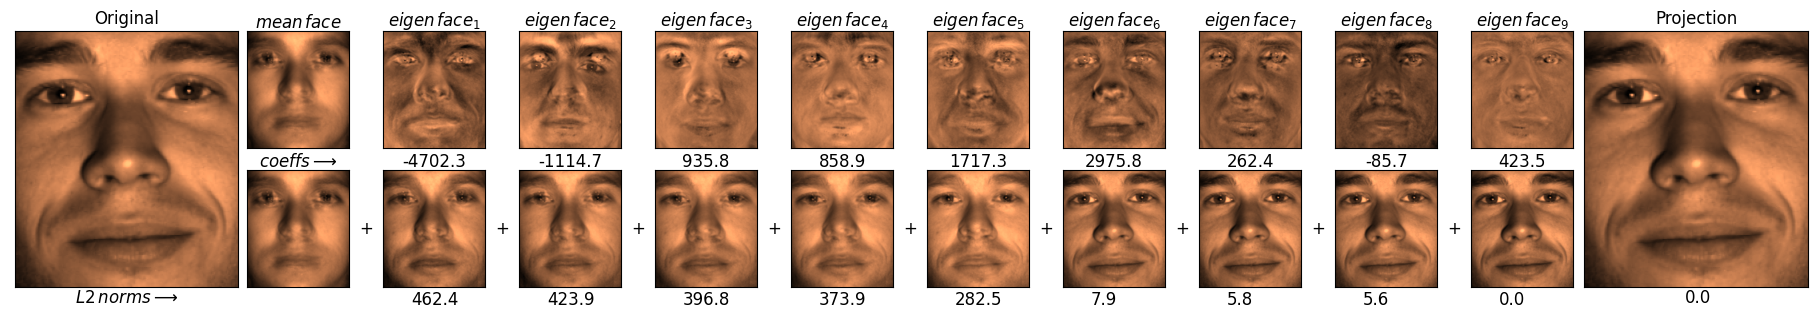

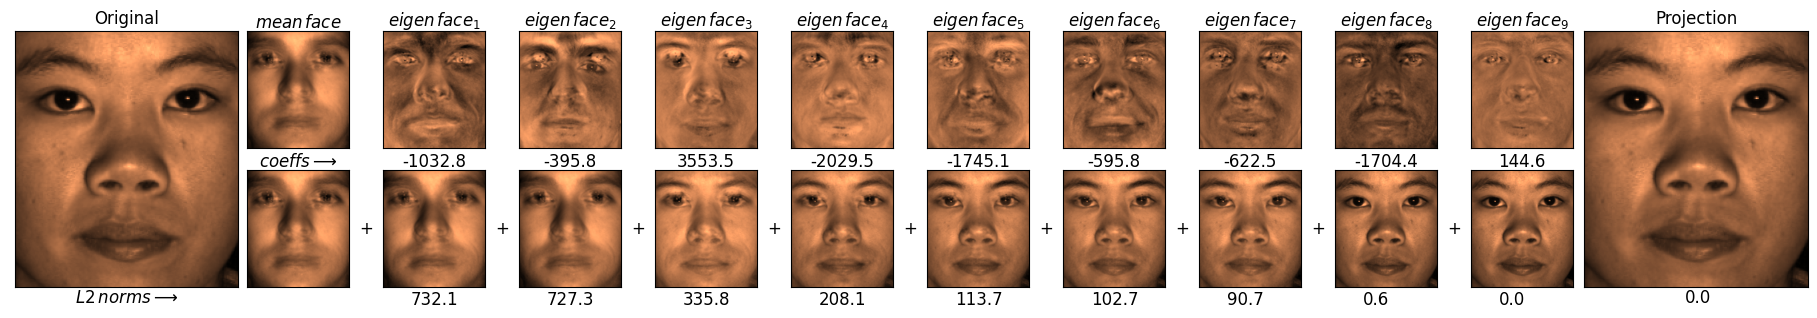

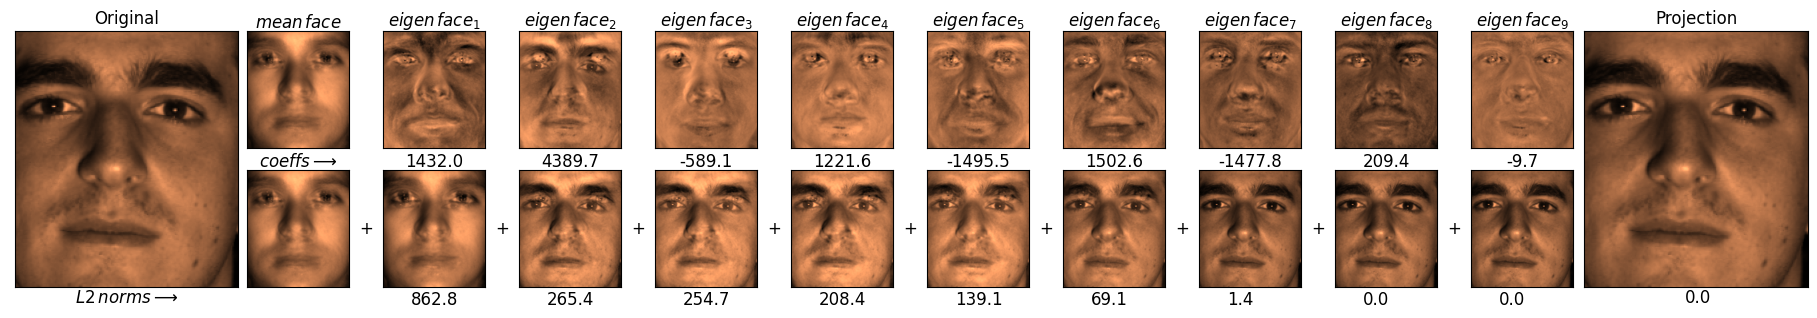

In [7]:
for id in range(len(X)):
    plot_pca_projection(
        im_face=X[id],
        mean_face=np.mean(X,axis=0),
        eigenfaces=eigenfaces,
        coeffs=coeffs[id],
        n_components=9,
        k_components=None,
        imshape=imshape,
        cmap=cmap
    )

### Function Definitions

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

cmap = 'copper'

def plot_faces(ims,imshape,cmap='gray'):
    fig = plt.figure(figsize=(18,3),constrained_layout=True, dpi=100)
    gs  = fig.add_gridspec(1,len(ims))
    for i,im in enumerate(ims):
        ax = fig.add_subplot(gs[0,i],xticks=[],yticks=[])
        ax.imshow(im.reshape(imshape),cmap=cmap)

def plot_pca_projection(
        im_face, 
        mean_face, 
        eigenfaces, 
        coeffs, 
        n_components=None, 
        k_components=None, 
        imshape=(0,0),
        cmap='gray'
    ):

    n_components = len(eigenfaces) if n_components is None else n_components
    k_components = n_components if k_components is None else k_components
        
    def plot_component(fig,pos,im,text='',left_align=True,plus=0,l2_norm=None):
        ax = fig.add_subplot(gs[pos[0],pos[1]],xticks=[],yticks=[])
        ax.imshow(im.reshape(imshape),cmap=cmap)
        ax.set_title(text,pad=-0.1)
        if left_align:    
            ax.text(-40,103,'+',fontsize=12,alpha=plus)
        if l2_norm is not None:
            ax.text(45,220,f'{l2_norm:.1f}',fontsize=12)

    fig = plt.figure(figsize=(18,3),constrained_layout=True, dpi=100)
    gs  = fig.add_gridspec(2,n_components+5)
    fig.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0, wspace=0)

    # Mean axes
    plot_component(fig,[0,2],im=mean_face,text=f'$mean\,face$',left_align=False)
    plot_component(fig,[1,2],im=mean_face,text=r'$coeffs\longrightarrow $',left_align=False)

    # Other axes
    proj_face = mean_face 
    for k in range(n_components):
        eig_face = eigenfaces[k]
        plot_component(fig,[0,k+3],im=eig_face,text=f'$eigen\,face_{k+1}$')

        if k in range(k_components):
            coeff = coeffs[k]
            proj_face += eig_face * coeff
            l2_norm = np.sum(np.square(im_face - proj_face)) / len(im_face)
            plot_component(fig,[1,k+3],im=proj_face,text=f'{coeffs[k]:4.1f}',plus=1,l2_norm=l2_norm)

    # Left & Right axes
    axL = fig.add_subplot(gs[:, :2],xticks=[],yticks=[]); axL.set_title('Original')
    axR = fig.add_subplot(gs[:,-2:],xticks=[],yticks=[]); axR.set_title('Projection')

    axL.imshow(im_face.reshape(imshape),cmap=cmap)
    axR.imshow(proj_face.reshape(imshape),cmap=cmap)

    axL.text(45,203,f'$L2 \, norms \longrightarrow$',fontsize=12)
    axR.text(75,203,f'{l2_norm:.1f}',fontsize=12)